In [1]:
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm

from gcv import SketchedSolveRidge, EnsembleGCV, SketchedRidgeParams
from gcv.sketches import SubsampledFourierSketchFactory, SketchSizeParams

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_cycle = ['o', 's', 'v', 'D', 'P', 'X', '*']

0.05 quantiles: [-0.9726793   0.84755131]
0.01 quantiles: [-1.41110679  1.40063149]


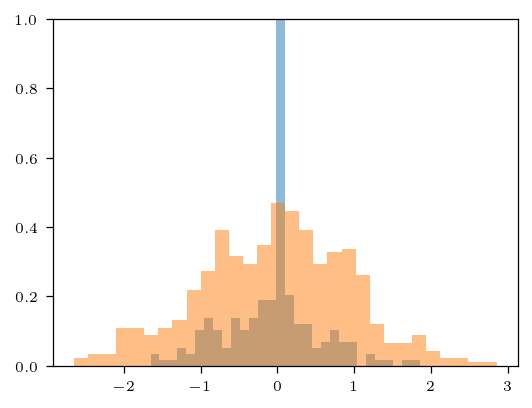

In [3]:
n = 500
p = 500
rng = np.random.default_rng(0)

def y_nonlin(z):
    # return z + rng.normal(scale=1, size=z.shape) * rng.choice([0, 1], p=[0.1, 0.9], size=z.shape)
    # return np.sign(z) * z ** 2
    # return np.sign(z) * np.abs(z) ** 3
    # return np.sign(z) * rng.choice([-1, 1], p=[0.1, 0.9], replace=True, size=z.shape)
    # return 1.5 * ((z > 1.5).astype(float) - (z < -1.5).astype(float))
    return np.sign(z) * np.maximum(np.abs(z) - 1, 0)

X = rng.normal(size=(n, p))
beta = rng.normal(scale=1 / np.sqrt(p), size=p)
z = X @ beta
y = y_nonlin(z)

print(f'0.05 quantiles: {np.quantile(y, [0.025, 0.975])}')
print(f'0.01 quantiles: {np.quantile(y, [0.005, 0.995])}')

plt.hist(y, bins=30, alpha=0.5, density=True)
plt.hist(z, bins=30, alpha=0.5, density=True)
plt.ylim(0, 1)
plt.show()

In [4]:
n_trials = 30
n_ens = 5
lamda = 1e-6
n0 = 75
p0 = 50
q0 = 10
p_vals = [0.01, 0.05] 
scale_factors = np.asarray([1, 2, 4, 8, 16, 32, 64]) #, 128]
rng = np.random.default_rng(0)

interval_widths = np.zeros((len(scale_factors), n_trials, len(p_vals)))
coverages = np.zeros((len(scale_factors), n_trials, len(p_vals)))

for i, scale in enumerate(scale_factors):

    n = n0 * scale
    p = p0 * scale
    q = q0 * scale
    params = SketchedRidgeParams(lamda, SketchSizeParams(q))

    for t in tqdm(range(n_trials), desc=f'scale={scale}'):

        X = rng.normal(size=(n, p))
        beta = rng.normal(scale=1 / np.sqrt(p), size=p)
        y = y_nonlin(X @ beta)

        X2 = rng.normal(size=(n, p))
        y2 = y_nonlin(X2 @ beta)
        
        factory = SubsampledFourierSketchFactory(p, transform='dct', rng=rng)

        ridges = [SketchedSolveRidge(X, y, factory) for _ in range(n_ens)]
        ens = EnsembleGCV(ridges)

        res = (y - ens.y_hat(params)) / ens.gcv_correction(params)
        conf_intervals = np.asarray([np.quantile(res, [p_val / 2, 1 - p_val / 2]) for p_val in p_vals])
        interval_widths[i, t, :] = conf_intervals[:, 1] - conf_intervals[:, 0]

        res2 = (y2 - ens.predict(X2, params))
        coverages[i, t, :] = np.mean((conf_intervals[:, :1] < res2[None, :]) & (res2[None, :] < conf_intervals[:, 1:]), axis=1)



scale=64: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it]


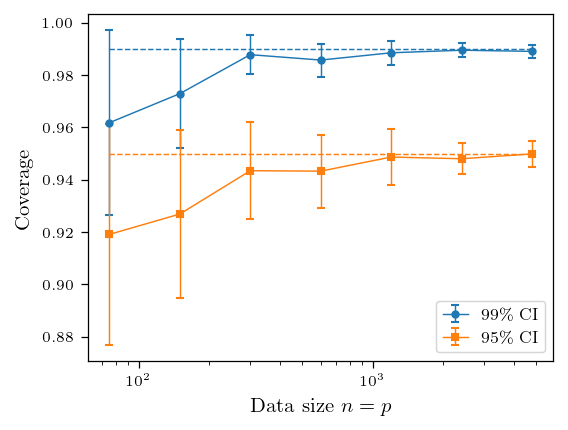

In [5]:
capsize = 2

for i, p_val in enumerate(p_vals):
    plt.errorbar(n0 * scale_factors, np.mean(coverages[:, :, i], axis=1), yerr=np.std(coverages[:, :, i], axis=1), label=f'{100 * (1 - p_val):.0f}\\% CI', color=color_cycle[i], marker=marker_cycle[i], capsize=capsize)
    plt.plot(n0 * scale_factors, np.ones_like(scale_factors) * (1 - p_val), '--', color=color_cycle[i])

plt.xlabel('Data size $n = p$')
plt.ylabel('Coverage')
plt.xscale('log')
plt.legend()
plt.show()

In [6]:
scale_factor = 20
q0s = np.asarray([4, 9, 14, 19, 24, 29, 34, 39, 44, 49])
print(q0s * scale_factor)
rng = np.random.default_rng(0)

interval_widths_by_q = np.zeros((len(q0s), n_trials, len(p_vals)))
coverages_by_q = np.zeros((len(q0s), n_trials, len(p_vals)))

n = n0 * scale_factor
p = p0 * scale_factor

for i, q0 in enumerate(q0s):

    q = q0 * scale_factor
    params = SketchedRidgeParams(lamda, SketchSizeParams(q))

    for t in tqdm(range(n_trials), desc=f'q0={q0}'):

        X = rng.normal(size=(n, p))
        beta = rng.normal(scale=1 / np.sqrt(p), size=p)
        y = y_nonlin(X @ beta)

        X2 = rng.normal(size=(n, p))
        y2 = y_nonlin(X2 @ beta)
        
        factory = SubsampledFourierSketchFactory(p, transform='dct', rng=rng)

        ridges = [SketchedSolveRidge(X, y, factory) for _ in range(n_ens)]
        ens = EnsembleGCV(ridges)

        res = (y - ens.y_hat(params)) / ens.gcv_correction(params)
        conf_intervals = np.asarray([np.quantile(res, [p_val / 2, 1 - p_val / 2]) for p_val in p_vals])
        interval_widths_by_q[i, t, :] = conf_intervals[:, 1] - conf_intervals[:, 0]

        res2 = (y2 - ens.predict(X2, params))
        coverages_by_q[i, t, :] = np.mean((conf_intervals[:, :1] < res2[None, :]) & (res2[None, :] < conf_intervals[:, 1:]), axis=1)

[ 80 180 280 380 480 580 680 780 880 980]


q0=49: 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


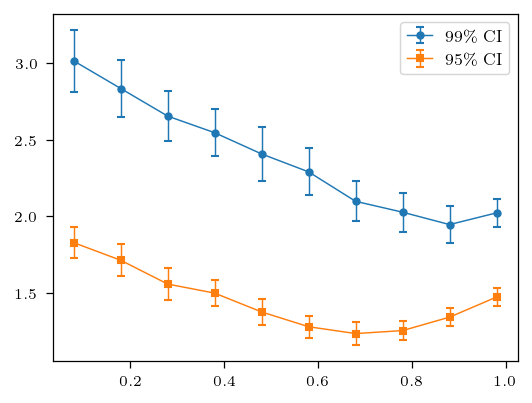

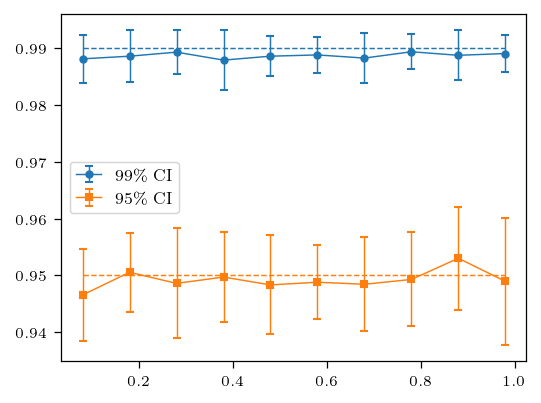

In [7]:
for i, p_val in enumerate(p_vals):
    plt.errorbar(q0s / p0, np.mean(interval_widths_by_q[:, :, i], axis=1), yerr=np.std(interval_widths_by_q[:, :, i], axis=1), label=f'{100 * (1 - p_val):.0f}\\% CI', color=color_cycle[i], marker=marker_cycle[i], capsize=capsize)

plt.legend()
plt.show()

for i, p_val in enumerate(p_vals):
    plt.errorbar(q0s / p0, np.mean(coverages_by_q[:, :, i], axis=1), yerr=np.std(coverages_by_q[:, :, i], axis=1), label=f'{100 * (1 - p_val):.0f}\\% CI', color=color_cycle[i], marker=marker_cycle[i], capsize=capsize)
    plt.plot(q0s / p0, np.ones_like(q0s) * (1 - p_val), '--', color=color_cycle[i])

plt.legend()
plt.show()

1500 1000 680


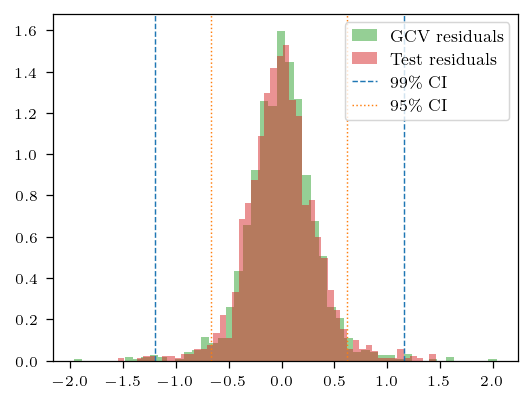

In [8]:
q0 = q0s[np.argmin(np.mean(interval_widths_by_q[:, :, 1], axis=1))]
n = n0 * scale_factor
p = p0 * scale_factor
q = q0 * scale_factor
print(n, p, q)
lamda = 1e-5
params = SketchedRidgeParams(lamda, SketchSizeParams(q))
rng = np.random.default_rng(0)

X = rng.normal(size=(n, p))
beta = rng.normal(scale=1 / np.sqrt(p), size=p)
y = y_nonlin(X @ beta)

X2 = rng.normal(size=(n, p))
y2 = y_nonlin(X2 @ beta)

factory = SubsampledFourierSketchFactory(p, transform='dct', rng=rng)

ridges = [SketchedSolveRidge(X, y, factory) for _ in range(n_ens)]
ens = EnsembleGCV(ridges)

res = (y - ens.y_hat(params)) / ens.gcv_correction(params)
conf_intervals = np.asarray([np.quantile(res, [p_val / 2, 1 - p_val / 2]) for p_val in p_vals])
res2 = (y2 - ens.predict(X2, params))

plt.hist(res, bins=50, alpha=0.5, density=True, color=color_cycle[2], label='GCV residuals')
plt.hist(res2, bins=50, alpha=0.5, density=True, color=color_cycle[3], label='Test residuals')
# plot confidence interval
linestyles = ['--', ':']
for i, p_val in enumerate(p_vals):
    plt.axvline(conf_intervals[i, 0], linestyle=linestyles[i], color=color_cycle[i], label=f'{100 * (1 - p_val):.0f}\\% CI')
    plt.axvline(conf_intervals[i, 1], linestyle=linestyles[i], color=color_cycle[i])

plt.legend()
plt.show()

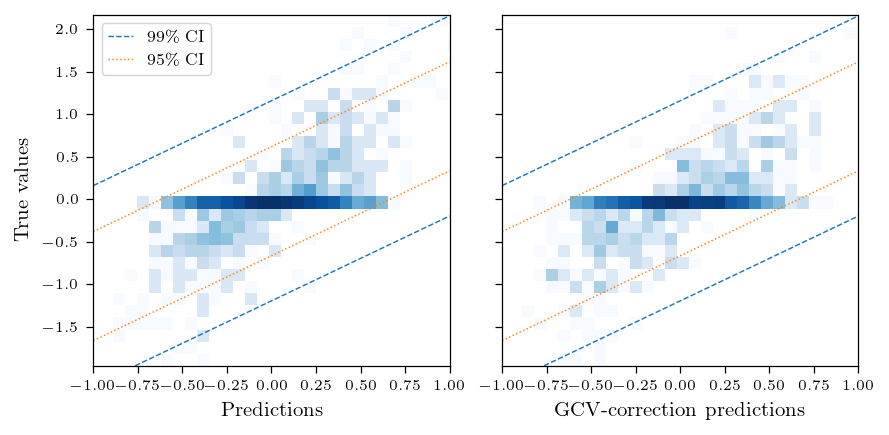

In [9]:
from matplotlib import colors

# create a 2D histogram of the predictions and true values for the test data
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

y2_hat = ens.predict(X2, params)
y_gcv = (ens.y_hat(params) - (1 - ens.gcv_correction(params)) * y) / ens.gcv_correction(params)

# create test data bins
binx = np.linspace(y2_hat.min(), y2_hat.max(), 30)
biny = np.linspace(y2.min(), y2.max(), 30)

axes[0].hist2d(ens.predict(X2, params), y2, bins=[binx, biny], cmap='Blues', norm=colors.LogNorm())
axes[0].set_xlabel('Predictions')
axes[0].set_ylabel('True values')
xlim = [-1, 1]
axes[0].set_xlim(xlim)
ylim = axes[0].get_ylim()

axes[1].hist2d(y_gcv, y, bins=[binx, biny], cmap='Blues', norm=colors.LogNorm())
axes[1].set_xlabel('GCV-correction predictions')
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)

for i, p_val in enumerate(p_vals):
    for ax in axes:
        ax.plot(xlim, xlim + conf_intervals[i, 0], linestyle=linestyles[i], color=color_cycle[i], label=f'{100 * (1 - p_val):.0f}\\% CI')
        ax.plot(xlim, xlim + conf_intervals[i, 1], linestyle=linestyles[i], color=color_cycle[i])

axes[0].legend()

plt.tight_layout()
plt.show()

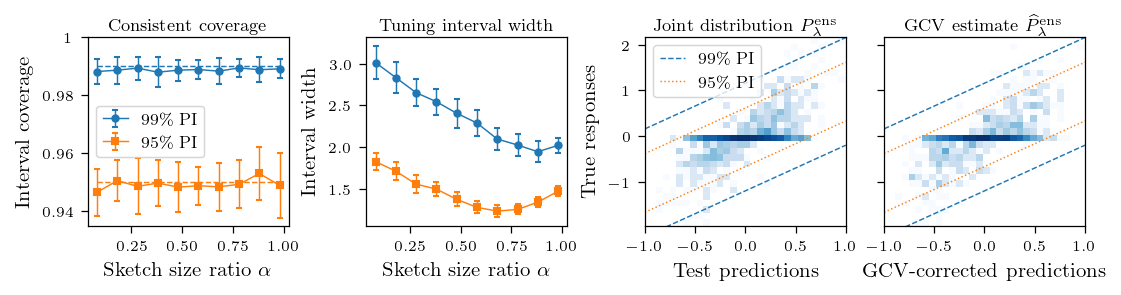

In [12]:
# plot previous plots together in one figure
fig, axes = plt.subplots(1, 4, figsize=(7.5, 1.8))
capsize = 1.5

# for i, p_val in enumerate(p_vals):
#     axes[0].errorbar(n0 * scale_factors, np.mean(coverages[:, :, i], axis=1), yerr=np.std(coverages[:, :, i], axis=1), label=f'{100 * (1 - p_val):.0f}\\% CI', color=color_cycle[i], marker=marker_cycle[i], capsize=capsize)
#     axes[0].plot(n0 * scale_factors, np.ones_like(scale_factors) * (1 - p_val), '--', color=color_cycle[i])

# axes[0].set_title('Consistent coverage')
# axes[0].set_xlabel('Data size $n = p$')
# axes[0].set_ylabel('Coverage')
# axes[0].set_xscale('log')
# axes[0].legend()

for i, p_val in enumerate(p_vals):
    axes[0].errorbar(q0s / p0, np.mean(coverages_by_q[:, :, i], axis=1), yerr=np.std(coverages_by_q[:, :, i], axis=1), label=f'{100 * (1 - p_val):.0f}\\% PI', color=color_cycle[i], marker=marker_cycle[i], capsize=capsize)
    axes[0].plot(q0s / p0, np.ones_like(q0s) * (1 - p_val), '--', color=color_cycle[i])

axes[0].set_title('Consistent coverage')
axes[0].set_xlabel(r'Sketch size ratio $\alpha$')
axes[0].set_ylabel('Interval coverage')
yticks = [0.94, 0.96, 0.98, 1]
axes[0].set_yticks(yticks, yticks)
axes[0].legend()

for i, p_val in enumerate(p_vals):
    axes[1].errorbar(q0s / p0, np.mean(interval_widths_by_q[:, :, i], axis=1), yerr=np.std(interval_widths_by_q[:, :, i], axis=1), label=f'{100 * (1 - p_val):.0f}\\% PI', color=color_cycle[i], marker=marker_cycle[i], capsize=capsize)

axes[1].set_title('Tuning interval width')
axes[1].set_xlabel(r'Sketch size ratio $\alpha$')
axes[1].set_ylabel('Interval width')

axes[2].hist2d(y2_hat, y2, bins=[binx, biny], cmap='Blues', norm=colors.LogNorm())
axes[2].set_xlabel('Test predictions')
axes[2].set_ylabel('True responses')
xlim = [-1, 1]
axes[2].set_xlim(xlim)
ylim = axes[2].get_ylim()
axes[2].set_title(r'Joint distribution $P_\lambda^{\mathrm{ens}}$')

axes[3].hist2d(y_gcv, y, bins=[binx, biny], cmap='Blues', norm=colors.LogNorm())
axes[3].set_xlabel('GCV-corrected predictions')
axes[3].set_xlim(xlim)
axes[3].set_ylim(ylim)
axes[3].set_yticklabels([])
axes[3].set_title(r'GCV estimate $\widehat{P}_\lambda^{\mathrm{ens}}$')

for i, p_val in enumerate(p_vals):
    for ax in axes[2:]:
        ax.plot(xlim, xlim + conf_intervals[i, 0], linestyle=linestyles[i], color=color_cycle[i], label=f'{100 * (1 - p_val):.0f}\\% PI')
        ax.plot(xlim, xlim + conf_intervals[i, 1], linestyle=linestyles[i], color=color_cycle[i])

axes[2].legend()

# axes[2].hist(res, bins=50, alpha=0.5, density=True, color=color_cycle[2], label='GCV residuals')
# axes[2].hist(res2, bins=50, alpha=0.5, density=True, color=color_cycle[3], label='Test residuals')
# # plot confidence interval
# linestyles = ['--', ':']
# for i, p_val in enumerate(p_vals):
#     axes[2].axvline(conf_intervals[i, 0], linestyle=linestyles[i], color=color_cycle[i], label=f'{100 * (1 - p_val):.0f}\\% CI')
#     axes[2].axvline(conf_intervals[i, 1], linestyle=linestyles[i], color=color_cycle[i])

# axes[2].set_title('Corrected residuals')
# axes[2].set_xlabel('Residual')
# # remove ylabels and ticks
# axes[2].set_yticks([])
# # axes[2].set_ylabel('Density')
# axes[2].legend(loc=(0.6, 0.6))

plt.tight_layout(pad=0.1)

# shift second plot to the right
axpos = axes[1].get_position()
# axpos.x0 += 0.015
# axpos.x1 += 0.015
axes[1].set_position(axpos)

# shift fourth plot to the left
axpos = axes[3].get_position()
axpos.x0 -= 0.035
axpos.x1 -= 0.035
axes[3].set_position(axpos)

plt.savefig('figures/prediction-intervals.pdf', bbox_inches='tight')
plt.show()